In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Using device:", DEVICE)


[INFO] Using device: cuda


In [3]:
# =====================
# DATASET PATHS
# =====================
LOL_DIR = Path("../data/datasets/LOL")

TRAIN_LOW = LOL_DIR / "our485/low"
TRAIN_HIGH = LOL_DIR / "our485/high"

VAL_LOW = LOL_DIR / "eval15/low"
VAL_HIGH = LOL_DIR / "eval15/high"

# =====================
# OUTPUT PATHS
# =====================
MODEL_SAVE_DIR = Path("../outputs/models/low_light")
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# =====================
# TRAINING PARAMS
# =====================
BATCH_SIZE = 8
NUM_EPOCHS = 500
LR = 1e-4


In [4]:
def read_image(path):
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.astype(np.float32) / 255.0

def to_tensor(img):
    return torch.from_numpy(img).permute(2, 0, 1)


In [5]:
from torch.utils.data import Dataset, DataLoader

class LOLDataset(Dataset):
    def __init__(self, low_dir, high_dir):
        self.low_imgs = sorted(
            list(low_dir.glob("*.png")) + list(low_dir.glob("*.jpg"))
        )
        self.high_dir = high_dir

        if len(self.low_imgs) == 0:
            raise RuntimeError(f"No images found in {low_dir}")

    def __len__(self):
        return len(self.low_imgs)

    def __getitem__(self, idx):
        low_path = self.low_imgs[idx]
        high_path = self.high_dir / low_path.name

        low = to_tensor(read_image(low_path))
        high = to_tensor(read_image(high_path))

        return low, high


In [6]:
train_dataset = LOLDataset(TRAIN_LOW, TRAIN_HIGH)
val_dataset = LOLDataset(VAL_LOW, VAL_HIGH)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)


In [7]:
class ZeroDCE(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv6 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv7 = nn.Conv2d(32, 24, 3, padding=1)

    def forward(self, x):
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x1))
        x3 = self.relu(self.conv3(x2))
        x4 = self.relu(self.conv4(x3))
        x5 = self.relu(self.conv5(x4))
        x6 = self.relu(self.conv6(x5))
        curves = torch.tanh(self.conv7(x6))
        return curves


In [8]:
def illumination_smoothness_loss(curves):
    return torch.mean(torch.abs(curves[:, :, :-1, :] - curves[:, :, 1:, :])) + \
           torch.mean(torch.abs(curves[:, :, :, :-1] - curves[:, :, :, 1:]))

def exposure_loss(img, target=0.6):
    gray = torch.mean(img, dim=1, keepdim=True)
    return torch.mean((gray - target) ** 2)

def color_constancy_loss(img):
    mean_rgb = torch.mean(img, dim=[2,3])
    r, g, b = mean_rgb[:,0], mean_rgb[:,1], mean_rgb[:,2]
    return torch.mean((r-g)**2 + (r-b)**2 + (g-b)**2)

def spatial_consistency_loss(img_low, img_high):
    return torch.mean(torch.abs(img_low - img_high))


In [9]:
def apply_curves(img, curves, n_iters=8):
    enhanced = img
    for i in range(n_iters):
        r = curves[:, i*3:(i+1)*3, :, :]
        enhanced = enhanced + r * (enhanced**2 - enhanced)
    return enhanced


In [10]:
import csv

CHECKPOINT_PATH = MODEL_SAVE_DIR / "checkpoint.pth"
LOG_PATH = MODEL_SAVE_DIR / "training_log.csv"


In [11]:
model = ZeroDCE().to(DEVICE)

optimizer = optim.Adam(
    model.parameters(),
    lr=LR,
    betas=(0.9, 0.999)
)

start_epoch = 0
best_loss = float("inf")
train_losses = []

# -------- Resume from checkpoint --------
if CHECKPOINT_PATH.exists():
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    best_loss = checkpoint["best_loss"]
    train_losses = checkpoint.get("train_losses", [])
    print(f"[INFO] Resuming from epoch {start_epoch}")
else:
    print("[INFO] Training from scratch")




if not LOG_PATH.exists():
    with open(LOG_PATH, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "epoch",
            "train_loss"
        ])


for epoch in range(start_epoch, NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0

    for low, high in tqdm(train_loader, desc=f"Epoch {epoch}"):
        low = low.to(DEVICE)
        high = high.to(DEVICE)

        curves = model(low)
        enhanced = apply_curves(low, curves)

        loss = (
            exposure_loss(enhanced) +
            color_constancy_loss(enhanced) +
            illumination_smoothness_loss(curves) +
            spatial_consistency_loss(enhanced, high)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    # -------- Save per-epoch model --------
    torch.save(
        {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "loss": epoch_loss
        },
        MODEL_SAVE_DIR / f"epoch_{epoch:03d}.pth"
    )

    # -------- Save BEST model --------
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "best_loss": best_loss
            },
            MODEL_SAVE_DIR / "best_model.pth"
        )

    # -------- Save CHECKPOINT --------
    torch.save(
        {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "best_loss": best_loss,
            "train_losses": train_losses
        },
        CHECKPOINT_PATH
    )

    # -------- Log to CSV --------
    with open(LOG_PATH, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, epoch_loss])

    print(f"[Epoch {epoch}] Train Loss = {epoch_loss:.6f}")


[INFO] Resuming from epoch 183


Epoch 183: 100%|██████████| 61/61 [02:27<00:00,  2.42s/it]


[Epoch 183] Train Loss = 0.198014


Epoch 184: 100%|██████████| 61/61 [02:25<00:00,  2.38s/it]


[Epoch 184] Train Loss = 0.198207


Epoch 185: 100%|██████████| 61/61 [02:25<00:00,  2.38s/it]


[Epoch 185] Train Loss = 0.199022


Epoch 186: 100%|██████████| 61/61 [02:25<00:00,  2.39s/it]


[Epoch 186] Train Loss = 0.197786


Epoch 187: 100%|██████████| 61/61 [02:27<00:00,  2.42s/it]


[Epoch 187] Train Loss = 0.198058


Epoch 188: 100%|██████████| 61/61 [02:28<00:00,  2.43s/it]


[Epoch 188] Train Loss = 0.197988


Epoch 189: 100%|██████████| 61/61 [02:33<00:00,  2.52s/it]


[Epoch 189] Train Loss = 0.197712


Epoch 190: 100%|██████████| 61/61 [02:26<00:00,  2.41s/it]


[Epoch 190] Train Loss = 0.197639


Epoch 191: 100%|██████████| 61/61 [02:25<00:00,  2.39s/it]


[Epoch 191] Train Loss = 0.197442


Epoch 192: 100%|██████████| 61/61 [02:26<00:00,  2.40s/it]


[Epoch 192] Train Loss = 0.198473


Epoch 193: 100%|██████████| 61/61 [02:26<00:00,  2.40s/it]


[Epoch 193] Train Loss = 0.198354


Epoch 194: 100%|██████████| 61/61 [02:26<00:00,  2.39s/it]


[Epoch 194] Train Loss = 0.197333


Epoch 195: 100%|██████████| 61/61 [02:25<00:00,  2.39s/it]


[Epoch 195] Train Loss = 0.197108


Epoch 196: 100%|██████████| 61/61 [02:26<00:00,  2.40s/it]


[Epoch 196] Train Loss = 0.197883


Epoch 197: 100%|██████████| 61/61 [02:26<00:00,  2.39s/it]


[Epoch 197] Train Loss = 0.197598


Epoch 198:   7%|▋         | 4/61 [00:12<02:52,  3.03s/it]


KeyboardInterrupt: 

[INFO] Loaded log with 198 epochs


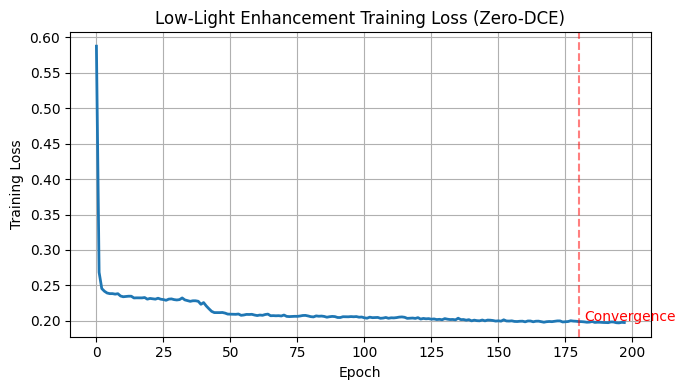

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# =====================
# LOAD LOG
# =====================
log_path = "../outputs/logs/training_log.csv"
df = pd.read_csv(log_path)

print("[INFO] Loaded log with", len(df), "epochs")

# =====================
# PLOT TRAINING LOSS
# =====================
plt.figure(figsize=(7,4))
plt.plot(df["epoch"], df["train_loss"], linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Low-Light Enhancement Training Loss (Zero-DCE)")
plt.grid(True)

# Mark convergence region
plt.axvline(x=180, color="red", linestyle="--", alpha=0.5)
plt.text(182, df["train_loss"].min() + 0.002, "Convergence", color="red")

plt.tight_layout()
plt.show()
